<a href="https://colab.research.google.com/github/BaichenTan/ExperimentData_Adv/blob/master/Placebo_Effect_Agreeableness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATT Estimation Tutorial

This tutorial gives a short example for how to estimate average treatment effect on the treated using machine learning methods

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from xgboost import XGBClassifier, XGBRegressor
import sklearn
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
from tabulate import tabulate

In [ ]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

# Import dataset

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/BaichenTan/ExperimentData_Adv/master/dataset_trimmed_agreeableness_final.csv")
data


,Unnamed: 0,...1,followup_fallstudyhours,followup_getwritinghelp,followup_metwithinstructor,followup_metwithfreetutor,followup_imptodowellatuoft,followup_depressed,followup_stressed,fathers_education,mothers_education,fall_meangrade_year1,exp_gradschl,agreeableness2,agreeableness,extraversion2,extraversion,study_habit
0,1,294,4,3,0,0,6,1,3,4,4,72.000000,1,-4.179262,0,1.563177,1,3
1,2,562,21,5,2,2,7,1,2,8,7,73.333336,1,-3.793850,0,0.284882,1,9
2,3,409,6,2,0,0,4,2,2,7,6,74.333336,1,-3.408439,0,-0.833625,0,2
3,4,211,20,4,5,0,7,2,3,6,7,71.333336,1,-3.215733,0,1.243603,1,9
4,5,324,8,2,0,0,6,0,3,1,2,83.333336,1,-3.215733,0,1.243603,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,1049,880,1,3,2,2,5,2,3,5,2,73.000000,1,1.987321,1,0.284882,1,7
1049,1050,919,5,5,1,1,4,2,1,6,2,85.500000,0,1.987321,1,0.444669,1,7
1050,1051,973,10,2,0,0,6,3,2,5,2,82.250000,1,1.987321,1,-1.472773,0,2
1051,1052,156,4,5,1,0,7,1,2,6,6,77.000000,1,2.180027,1,0.764243,1,6


## Counfounders, Outcome, and Treatment

In [ ]:
#create a dataset of confounders
confounders_without_Mediator = data[['fathers_education', 'mothers_education']]
confounders_with_allMediators = data[["followup_fallstudyhours", "followup_imptodowellatuoft", "followup_depressed", "followup_stressed", "fathers_education",	"mothers_education", "exp_gradschl", "study_habit"]]
confounders_with_mediatorStudyHours = data[["followup_fallstudyhours", "followup_imptodowellatuoft", "followup_depressed", "followup_stressed", "fathers_education",	"mothers_education", "exp_gradschl"]]
confounders_with_mediatorStudyHabits = data[["study_habit","followup_imptodowellatuoft", "followup_depressed", "followup_stressed", "fathers_education",	"mothers_education", "exp_gradschl"]]
outcome = data['fall_meangrade_year1']
treatment = data['extraversion']
placebo = data['agreeableness']

## Specify Nuisance Function Models

The next step is to specify models for the conditional expected outcome and propensity score

## Q model

### Q model with randomforest

In [ ]:
# specify a model for the conditional expected outcome

# make a function that returns a sklearn model for later use in k-folding
def make_Qmodel_randomForest():
  return RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=500, max_depth=3)

Qmodel_randomForest = make_Qmodel_randomForest()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

### Q model with linear regression

In [ ]:
def make_Qmodel_linearRegression():
  return LinearRegression()

Qmodel_LinearRegression = make_Qmodel_linearRegression()



### Q model with XGBoost 

In [ ]:
def make_Qmodel_XGBoost():
  return XGBRegressor(n_jobs=1, objective = "reg:squarederror", random_state=RANDOM_SEED)

Qmodel_XGBRegressor = make_Qmodel_XGBoost()

## g model

### g model with RandomForest

In [ ]:
# specify a model for the propensity score

def make_gmodel_randomForest():

  return RandomForestClassifier(n_estimators=100, max_depth=10)

gmodel_randomForest = make_gmodel_randomForest()

### g model with logistic regression

In [ ]:
def make_gmodel_logisticRegression():
  return LogisticRegression(max_iter=1000)

gmodel_LogisticRegression = make_gmodel_logisticRegression()

### g model with XGBoost

In [ ]:
def make_gmodel_XGBClassifier():
  return XGBClassifier(use_label_encoder=False, n_jobs=1, objective='binary:logistic',eval_metric = 'logloss', random_state =RANDOM_SEED)

gmodel_XGBClassifier = make_gmodel_XGBClassifier()

## Use cross fitting to get get predicted outcomes and propensity scores for each unit

In [ ]:
# helper functions to implement the cross fitting

def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    """
    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    for train_index, test_index in kf.split(X, A):
      X_train = X.loc[train_index]
      A_train = A.loc[train_index]
      g = make_model()
      g.fit(X_train, A_train)

      # get predictions for split
      predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0
    return predictions


def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str):
    """
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"

    """
    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
      kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point 
    X0 = X_w_treatment.copy()
    X0["A"] = 0
    X1 = X_w_treatment.copy()
    X1["A"] = 1

    
    for train_index, test_index in kf.split(X_w_treatment, y):
      X_train = X_w_treatment.loc[train_index]
      y_train = y.loc[train_index]
      q = make_model()
      q.fit(X_train, y_train)

      if output_type =='binary':
        predictions0[test_index] = q.predict_proba(X0.loc[test_index])[:, 1]
        predictions1[test_index] = q.predict_proba(X1.loc[test_index])[:, 1]
      elif output_type == 'continuous':
        predictions0[test_index] = q.predict(X0.loc[test_index])
        predictions1[test_index] = q.predict(X1.loc[test_index])

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

## Exclude the moderate units in the g and Q model


## Combine predicted values and data into estimate of ATU

In [ ]:
def att_aiptw(Q0, Q1, g, A, Y, prob_t=None):
  """
  # Double ML estimator for the ATT
  This uses the ATT specific scores, see equation 3.9 of https://www.econstor.eu/bitstream/10419/149795/1/869216953.pdf
  """

  if prob_t is None:
    prob_t = 1 - A.mean() # estimate marginal probability of treatment

  tau_hat = (A*((1-g)/g)*(Y-Q1) - (1-A)*(Y-Q1)).mean()/ prob_t
  
  scores = (A*((1-g)/g)*(Y-Q1) - (1-A)*(Y-Q1) - tau_hat*(1-A)) / prob_t
  n = Y.shape[0] # number of observations
  std_hat = np.std(scores) / np.sqrt(n)

  return tau_hat, std_hat


In [ ]:
def ate_aiptw(Q0, Q1, g, A, Y, prob_t=None):
  """
  # Double ML estimator for the ATE
  """

  tau_hat = (Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g)).mean()
  
  scores = Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g) - tau_hat
  n = Y.shape[0] # number of observations
  std_hat = np.std(scores) / np.sqrt(n)

  return tau_hat, std_hat


# Placebo Effect

(array([0.05969118, 0.05969118, 0.17907355, 0.3581471 , 1.38782001,
        5.83481318, 0.85059936, 0.96998173, 0.25368753, 0.08953678]),
 array([0.00428571, 0.10385714, 0.20342857, 0.303     , 0.40257143,
        0.50214286, 0.60171429, 0.70128571, 0.80085714, 0.90042857,
        1.        ]),
 <a list of 10 Patch objects>)

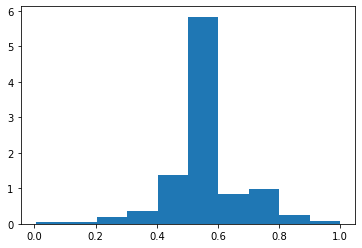

In [ ]:
#check the overlap conditions using randomForest
#get the propensity score function
g1_P = treatment_k_fold_fit_and_predict(make_gmodel_randomForest, X=confounders_without_Mediator, 
                                      A=placebo, n_splits=10)
g1_P_overlap = np.concatenate((g1_P[:315],g1_P[695:]))
hist(g1_P_overlap, density=True)

(array([ 1.86896496,  6.85287152, 22.94673645, 11.83677808,  4.25708685,
         1.34980803,  6.02222043,  8.09884816,  4.88007517,  1.76513357]),
 array([0.49784265, 0.51215319, 0.52646374, 0.54077429, 0.55508484,
        0.56939539, 0.58370594, 0.59801649, 0.61232703, 0.62663758,
        0.64094813]),
 <a list of 10 Patch objects>)

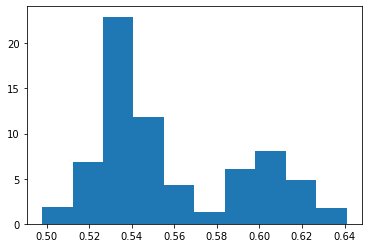

In [ ]:
g2_P = treatment_k_fold_fit_and_predict(make_gmodel_logisticRegression, X=confounders_without_Mediator, 
                                      A=placebo, n_splits=10)
g2_P_overlap = np.concatenate((g2_P[:315],g2_P[695:]))
hist(g2_P_overlap, density=True)

(array([0.0562414 , 0.07498853, 0.26245986, 0.63740251, 5.83035821,
        3.37448385, 1.34979354, 0.73113817, 0.28120699, 0.01874713]),
 array([0.15023658, 0.22949585, 0.30875512, 0.3880144 , 0.46727367,
        0.54653294, 0.62579222, 0.70505149, 0.78431076, 0.86357004,
        0.94282931]),
 <a list of 10 Patch objects>)

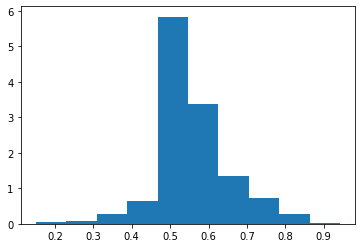

In [ ]:
g3_P = treatment_k_fold_fit_and_predict(make_gmodel_XGBClassifier, X=confounders_without_Mediator, 
                                      A=placebo, n_splits=10)
g3_P_overlap = np.concatenate((g3_P[:315],g3_P[695:]))
hist(g3_P_overlap, density=True)

### Calculate Placebo Effect using RandomForest

In [ ]:
def exclude_moderate(df: pd.DataFrame):
  df = df.drop(data.index[315:695])
  return df

In [ ]:
Q0_RF_P,Q1_RF_P = outcome_k_fold_fit_and_predict(make_Qmodel_randomForest, 
                                             X=confounders_without_Mediator, y=outcome, 
                                             A=placebo, n_splits=10, output_type="continuous")

In [ ]:
data_and_nuisance_estimates_RF_P = pd.DataFrame({'g': g1_P, 'Q0': Q0_RF_P, 'Q1': Q1_RF_P, 'A': placebo, 'Y': outcome})
data_and_nuisance_estimates_RF_P = exclude_moderate(data_and_nuisance_estimates_RF_P)


In [ ]:
tau_hat_RF_P, std_hat_RF_P = att_aiptw(**data_and_nuisance_estimates_RF_P)
print(f"The estimate using RandomForest is {tau_hat_RF_P} pm {1.96*std_hat_RF_P}")

The estimate using RandomForest is -4.735492327205506 pm 8.943276284859685


### Calculate Placebo Effect using Logistic Regression

In [ ]:
Q0_LR_P,Q1_LR_P = outcome_k_fold_fit_and_predict(make_Qmodel_linearRegression, 
                                             X=confounders_without_Mediator, y=outcome, 
                                             A=placebo, n_splits=10, output_type="continuous")

In [ ]:
data_and_nuisance_estimates_LR_P = pd.DataFrame({'g': g2_P, 'Q0': Q0_LR_P, 'Q1': Q1_LR_P, 'A': placebo, 'Y': outcome})
data_and_nuisance_estimates_LR_P = exclude_moderate(data_and_nuisance_estimates_LR_P)
data_and_nuisance_estimates_LR_P.head()

,g,Q0,Q1,A,Y
0,0.568357,69.409067,69.618939,0,72.000000
1,0.523014,71.191488,71.832179,0,73.333336
2,0.535634,71.079421,71.722667,0,74.333336
3,0.516596,71.014851,71.658097,0,71.333336
4,0.601872,67.375813,68.233413,0,83.333336


In [ ]:
tau_hat_LR_P, std_hat_LR_P = att_aiptw(**data_and_nuisance_estimates_LR_P)
print(f"The estimate using Logistic Regression is {tau_hat_LR_P} pm {1.96*std_hat_LR_P}")

The estimate using Logistic Regression is 0.47354212276065005 pm 1.8256784464215154


### Calculate Plcebo Effect using XGBoost

In [ ]:
Q0_XG_P,Q1_XG_P = outcome_k_fold_fit_and_predict(make_Qmodel_XGBoost, 
                                             X=confounders_without_Mediator, y=outcome, 
                                             A=placebo, n_splits=10, output_type="continuous")

In [ ]:
data_and_nuisance_estimates_XG_P = pd.DataFrame({'g': g3_P, 'Q0': Q0_XG_P, 'Q1': Q1_XG_P, 'A': placebo, 'Y': outcome})
data_and_nuisance_estimates_XG_P = exclude_moderate(data_and_nuisance_estimates_XG_P)
data_and_nuisance_estimates_XG_P.head()

,g,Q0,Q1,A,Y
0,0.425523,70.126801,74.089684,0,72.000000
1,0.532893,69.813889,69.862900,0,73.333336
2,0.530421,73.734901,73.343521,0,74.333336
3,0.538896,74.698303,74.618530,0,71.333336
4,0.510170,70.006950,70.087860,0,83.333336


In [ ]:
tau_hat_XG_P, std_hat_XG_P = att_aiptw(**data_and_nuisance_estimates_XG_P)
print(f"The estimate using XGBoost is {tau_hat_XG_P} pm {1.96*std_hat_XG_P}")

The estimate using XGBoost is 0.1893047136440993 pm 1.8805321999269913


# The table of results

In [ ]:
Plb_table = [['Outcome','Type of causal effect', 'Model', 'Estimate','p/m', 'Standard Error'],
                 ['Fall_grade','Placebo Effect on Agreealeness', 'RandomForest',tau_hat_RF_P,1.96*std_hat_RF_P,std_hat_RF_P], 
                 ['Fall_grade','Placebo Effect on Agreealeness', 'Logistic Regression',tau_hat_LR_P,1.96*std_hat_LR_P,std_hat_LR_P],
                 ['Fall_grade','Placebo Effect on Agreealeness', 'XGBoost',tau_hat_XG_P,1.96*std_hat_XG_P,std_hat_XG_P]]

In [ ]:
df_plb = pd.DataFrame(Plb_table)
df_plb.columns = df_plb.iloc[0]
df_plb = df_plb[1:]
df_plb

,Outcome,Type of causal effect,Model,Estimate,p/m,Standard Error
1,Fall_grade,Placebo Effect on Agreealeness,RandomForest,-4.735492,8.943276,4.562896
2,Fall_grade,Placebo Effect on Agreealeness,Logistic Regression,0.473542,1.825678,0.931469
3,Fall_grade,Placebo Effect on Agreealeness,XGBoost,0.189305,1.880532,0.959455
